In [1]:
import numpy as np
import torch

In [2]:
from collections import OrderedDict
from utils.tokenizer import SimpleTokenizer
import models.ULIP_models as models
from main import get_args_parser
import argparse
from utils import utils


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from ULIP_ShapeNet_Dataset.ULIP_ShapeNet import ULIP_ShapeNet

Current support class

In [4]:
# Define class names and descriptions
shapenet_classes = ['plane', 'table', 'chair']

descriptions = []
for i, sn_class in enumerate(shapenet_classes):
    descriptions.append(f'This is an image of a 3D rendering {sn_class}')

print(descriptions)

['This is an image of a 3D rendering plane', 'This is an image of a 3D rendering table', 'This is an image of a 3D rendering chair']


Load the ULIP ShapeNet dataset

In [5]:
keyword = "plane"
# keyword = None

dataset = ULIP_ShapeNet(keyword=keyword)
print(len(dataset))
print(dataset.total_images())

data, RGB_imgs_show = dataset.process_index(index=34, show_images=True)

2860
2860


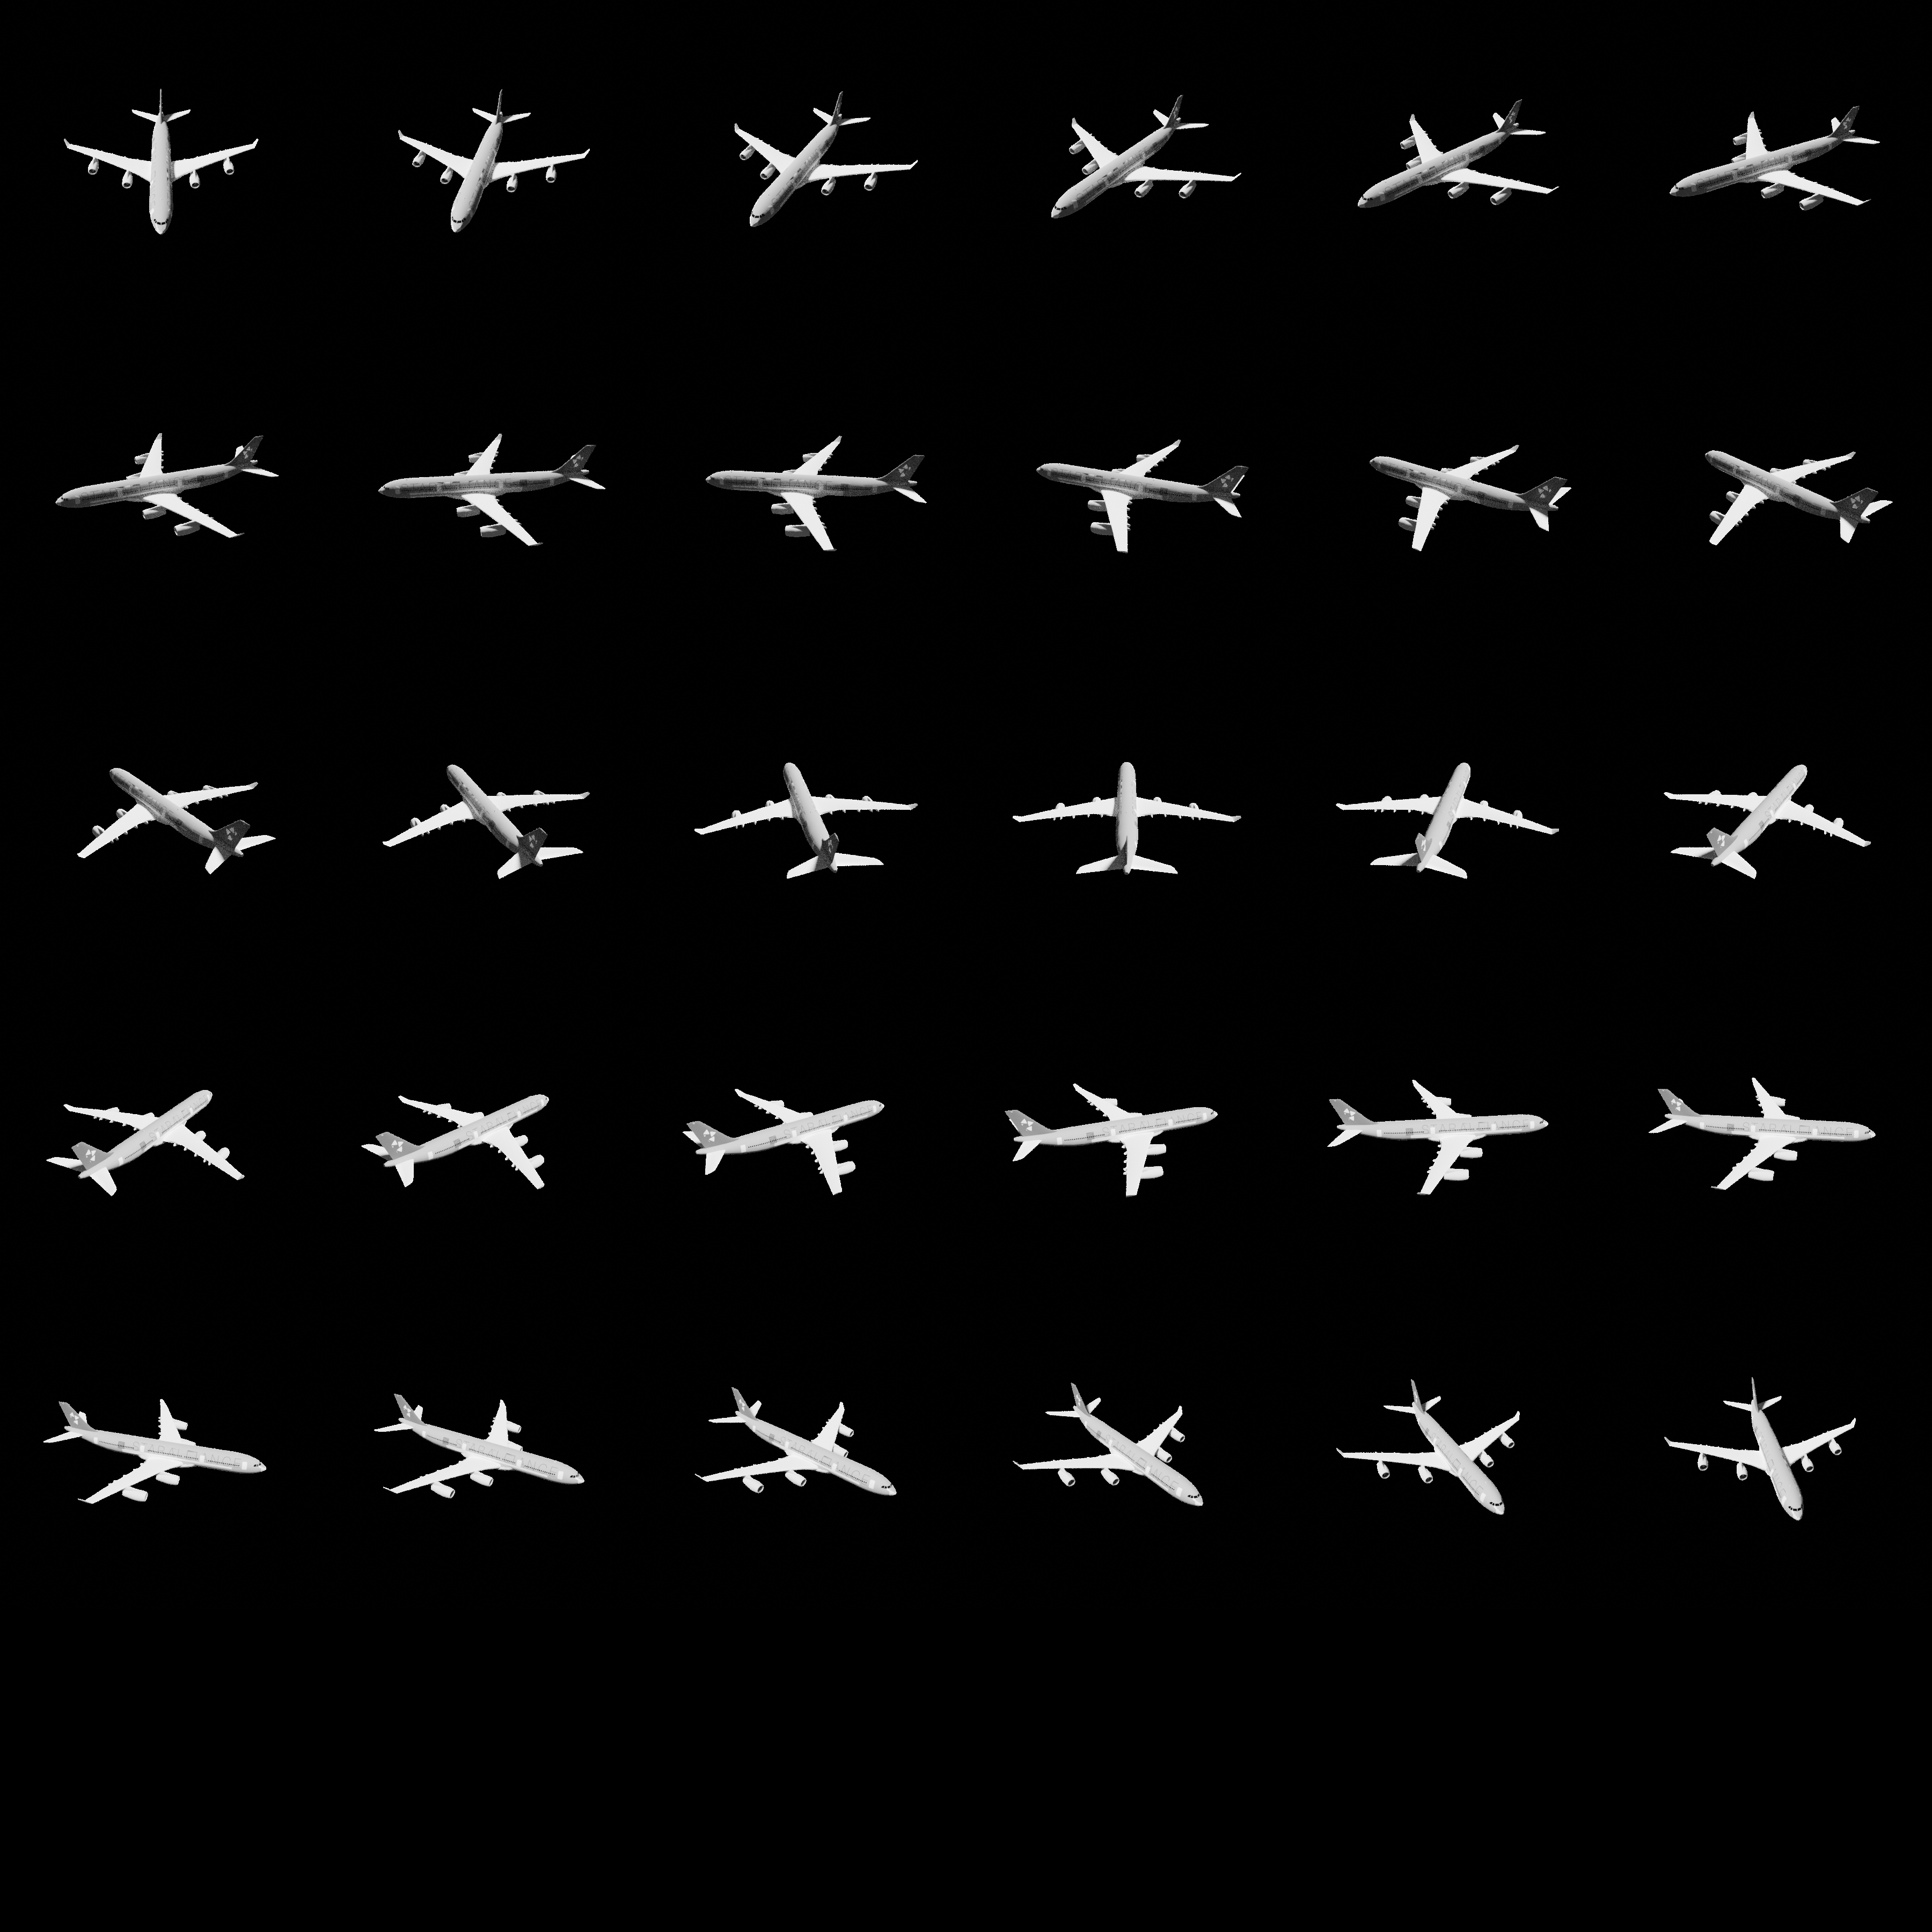

In [6]:
RGB_imgs_show

In [8]:
dataset.visualize_pointcloud(data["pointcloud_np"])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000104…

In [9]:
angle_idx = np.random.randint(len(dataset.all_angles)) + 1

img = data[f'angle_{angle_idx}']['image']
captions = data[f'angle_{angle_idx}']['captions']

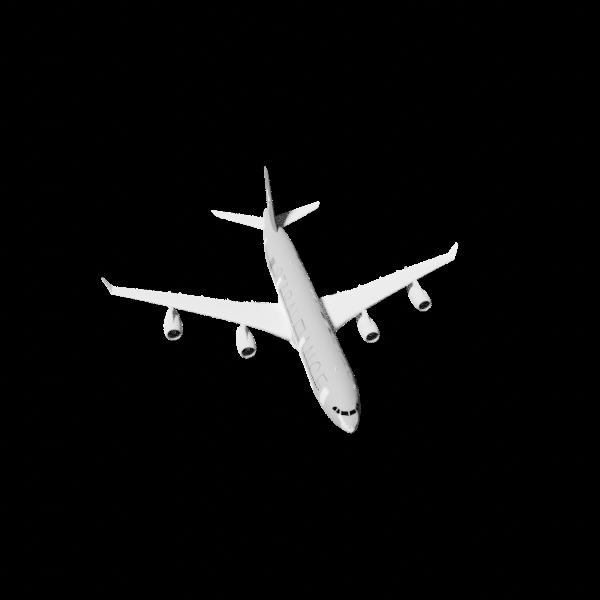

In [10]:
img

In [11]:
captions

['an airplane is shown in a grey background',
 'a large airplane is flying above a gray background',
 'a close up of a passenger jet in flight',
 'a picture of a plane with all the windows blacked out',
 'a picture of a jet flying in the sky',
 'a jetliner flying in the sky above the gray background',
 'a plane flying through the air during the day',
 'an airplane flying in the air with no people on it',
 'a white airplane is flying overhead',
 'a white airplane flying in the sky']

Load the ULIP pretrained 3D encoder

In [3]:
def create_fake_args():
    parser = argparse.ArgumentParser('ULIP training and evaluation', parents=[get_args_parser()])
    fake_args = parser.parse_args([])  # 使用空列表初始化命名空间
    # 手动设置每个参数的值
    fake_args.output_dir = './outputs'
    # fake_args.npoints = 8192
    fake_args.npoints = 10000
    fake_args.model = 'ULIP2_PointBERT_Colored'
    fake_args.gpu = 1
    fake_args.test_ckpt_addr = './pretrained_models/pointbert_ULIP-2.pt'
    fake_args.evaluate_3d_ulip2 = True
    return fake_args

args = create_fake_args()

In [4]:
ckpt = torch.load(args.test_ckpt_addr, map_location='cpu')
state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    state_dict[k.replace('module.', '')] = v

print("=> creating model: {}".format(args.model))


=> creating model: ULIP2_PointBERT_Colored


In [5]:
model = getattr(models, args.model)(args=args)
model.cuda()
model.load_state_dict(state_dict, strict=False)
print("=> loaded pretrained checkpoint '{}'".format(args.test_ckpt_addr))

Get openclip model:
Finished loading the openclip model.
training from scratch for pointbert.
model size:
32.50M
=> loaded pretrained checkpoint './pretrained_models/pointbert_ULIP-2.pt'


In [6]:
tokenizer = SimpleTokenizer()

In [ ]:
model.eval()

with torch.no_grad():
    text_features = []
    for l in labels:
        texts = [t.format(l) for t in templates]
        texts = tokenizer(texts).cuda(args.gpu, non_blocking=True)
        if len(texts.shape) < 2:
            texts = texts[None, ...]
        class_embeddings = utils.get_model(model).encode_text(texts)
        class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
        class_embeddings = class_embeddings.mean(dim=0)
        class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
        text_features.append(class_embeddings)
    text_features = torch.stack(text_features, dim=0)

    

In [ ]:
with torch.no_grad():
    for i, (pc, target, target_name) in enumerate(test_loader):
        for name in target_name:
            per_class_stats[name] += 1

        pc = pc.cuda(args.gpu, non_blocking=True)
        target = target.cuda(args.gpu, non_blocking=True)

        # encode pc
        pc_features = utils.get_model(model).encode_pc(pc)
        pc_features = pc_features / pc_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logits_per_pc = pc_features @ text_features.t()
